In [1]:
# Dependencies
import tweepy
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

from localenv import (consumer_key, 
                      consumer_secret, 
                      access_token, 
                      access_token_secret)

In [2]:
# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [3]:
# Target Search
news_outlets = ["@BBC", "@CBS", "@CNN", "@Fox", "@nytimes"]
sentiments = []

In [4]:
for outlet in news_outlets:
    public_tweets = api.user_timeline(outlet, count=100, result_type='recent')
    tweetnumber = 1       
    for tweet in public_tweets:
        #print("Tweet %s: %s" % (counter, tweet["text"]))
        results = analyzer.polarity_scores(tweet["text"])
        compound = results["compound"]
        pos = results["pos"]
        neu = results["neu"]
        neg = results["neg"]
        tweets_ago = tweetnumber
        sentiments.append({"Media Source": outlet,
                           "Date": tweet["created_at"],
                           "Compound": compound,
                           "Positive": pos,
                           "Neutral": neu,
                           "Negative": neg,
                           "Tweets Ago": tweetnumber})
        tweetnumber +=1


In [32]:
# Convert sentiments to DataFrame
sentiments_pd = pd.DataFrame.from_dict(sentiments)
sentiments_pd['Media Source'] = sentiments_pd['Media Source'].map(lambda x: x.lstrip('@'))
sentiments_pd.head()

,Compound,Date,Media Source,Negative,Neutral,Positive,Tweets Ago
0,0.6068,Sun Mar 11 21:39:32 +0000 2018,BBC,0.000,0.763,0.237,1
1,0.6908,Sun Mar 11 21:22:19 +0000 2018,BBC,0.000,0.678,0.322,2
2,0.3612,Sun Mar 11 21:02:37 +0000 2018,BBC,0.000,0.848,0.152,3
3,0.8610,Sun Mar 11 20:00:07 +0000 2018,BBC,0.000,0.570,0.430,4
4,0.7650,Sun Mar 11 19:54:20 +0000 2018,BBC,0.048,0.662,0.290,5


In [33]:
# colors
news_colors={"BBC": "lightblue",
             "CBS": "green", 
             "CNN": "red",
             "Fox": "blue",
             "nytimes": "yellow"}

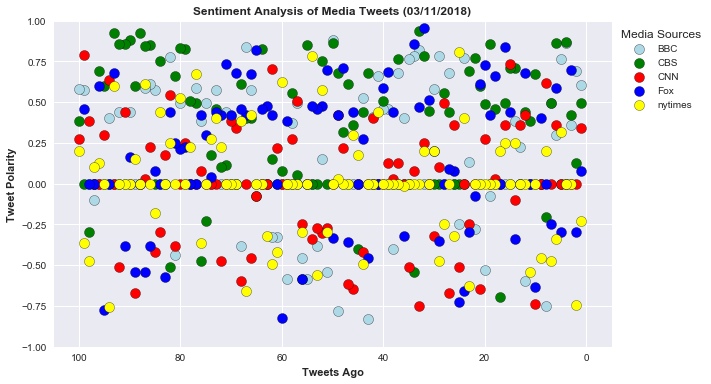

In [34]:
# Create sentiment plot
sns.set()
plt.figure(figsize=(10, 6))
plt.xlabel("Tweets Ago", fontweight='bold')
plt.ylabel("Tweet Polarity", fontweight='bold')
plt.title("Sentiment Analysis of Media Tweets (%s)" % (time.strftime("%m/%d/%Y")), fontweight='bold')
plt.xlim(105, -5, -1)
plt.ylim(-1, 1)
for newsname in news_colors.keys():
    df = sentiments_pd[sentiments_pd['Media Source']==newsname]
    sentiment_analysis = plt.scatter(df["Tweets Ago"], df["Compound"], label=newsname, 
                                     color=news_colors[newsname], edgecolor = "black", s=100)
plt.legend(bbox_to_anchor = (1, 1), title = 'Media Sources')    

sentiment_analysis.figure.savefig('SentimentAnalysis.png')    

In [35]:
media_compound = sentiments_pd.groupby("Media Source")["Compound"].mean()
media_compound

Media Source
BBC        0.166430
CBS        0.329151
CNN        0.011416
Fox        0.157788
nytimes    0.012336
Name: Compound, dtype: float64

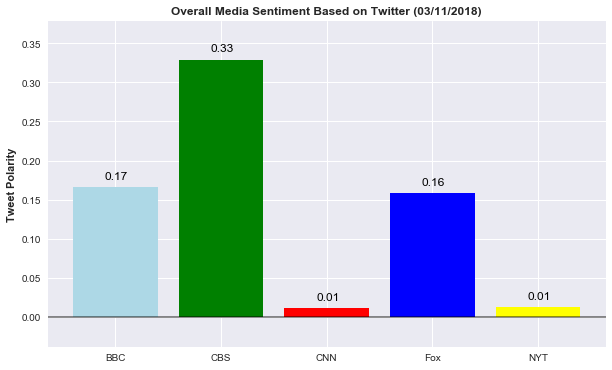

In [36]:
x_axis = np.arange(len(media_compound))
x = media_compound.index
y = media_compound.values

# Create bar chart
sns.set()
plt.figure(figsize=(10, 6))

plt.bar(x, y, color=['lightblue', 'green', 'red', 'blue', 'yellow'])
plt.ylim(min(y)-0.05, max(y)+0.05)
plt.ylabel("Tweet Polarity", fontweight='bold')
plt.axhline(y=0, color='black', alpha=0.5)

for i, v in enumerate(media_compound):
    plt.text(i-0.1, v+.01, "{:.2f}".format(v), color='black')

x_labels = ["BBC", "CBS", "CNN", "Fox", "NYT"]
x_locations = [value for value in x_axis]
plt.xticks(x_locations, x_labels)
plt.title("Overall Media Sentiment Based on Twitter (%s)" % (time.strftime("%m/%d/%Y")), fontweight='bold')

plt.savefig('Overall Media Sentiment Based on Twitter.png')